In [1]:
# !python3 -m pip install -U --no-cache-dir  \
#             --config-settings="--global-option=build_ext" \
#             --config-settings="--global-option=-I$(brew --prefix graphviz)/include/" \
#             --config-settings="--global-option=-L$(brew --prefix graphviz)/lib/" \
#             pygraphviz

In [19]:
import os
from pymongo import MongoClient
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Set up MongoDB connection using environment variables
MONGO_URI = os.getenv("MONGODB_URI")
DB_NAME = os.getenv("MONGODB_DB_NAME")
COLLECTION_NAME = "si"  # Collection storing shipping instructions

# Create MongoDB client and connect to the specific database and collection
client = MongoClient(MONGO_URI)
db = client[DB_NAME]
collection = db[COLLECTION_NAME]

def fetch_shipping_instruction(booking_reference):
    """
    Fetch the shipping instruction from MongoDB based on the booking reference.
    """
    return collection.find_one({'bookingReference': booking_reference})


In [20]:
booking_reference= "CHERRY202409072244"

In [21]:
si_data = fetch_shipping_instruction(booking_reference)

In [22]:
si_data

{'_id': ObjectId('66e1562f0abd52a6a79a2ff6'),
 'bookingReference': 'CHERRY202409072244',
 'voyageDetails': {'vesselName': 'APL TEMASEK', 'voyageNumber': '2024581E'},
 'routeDetails': {'placeOfReceipt': 'NINGBO',
  'portOfLoading': 'NINGBO',
  'portOfDischarge': 'YANTIAN',
  'placeOfDelivery': 'YANTIAN'},
 'paymentDetails': {'freightPaymentTerms': 'COLLECT',
  'freightPayableAt': 'ROTTERDAM, NETHERLANDS'},
 'documentationDetails': {'blType': 'NEGOTIABLE',
  'numberOfOriginalBLs': 3,
  'numberOfCopies': 0},
 'partyDetails': {'shipper': {'name': 'SHIPPER 5029',
   'address': 'NO. 188, SHANXI ROAD, NINGBO, CHINA',
   'telephone': '+86 574 8765 4321',
   'email': 'INFO@CHINAIMPORTEXPORT.COM'},
  'consignee': {'name': 'EUROTECH TRADING BV',
   'address': 'WATERLOO PLAZA, 121-123 WATERLOOPLEIN, 1011 PG AMSTERDAM, NETHERLANDS',
   'taxId': 'NL856321452B01',
   'president': 'MR. JAN VAN DER WIEL',
   'telephone': '+31 20 624 3500',
   'fax': '+31 20 624 3501'},
  'notifyParty': {'name': 'EUROTE

In [ ]:
# !pip install langchain-community 
# !pip install langchain-google-genai

In [2]:
import os
import json
from bson import json_util
from typing import List, Dict, TypedDict, Annotated, Sequence, Optional
# from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import ChatOpenAI
from pymongo import MongoClient
from operator import add
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph, START, END
from langchain.prompts import PromptTemplate
from langchain.schema import StrOutputParser

from dotenv import load_dotenv

load_dotenv()

True

In [3]:
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

llm = ChatOpenAI(temperature=0, 
                    model_name="gpt-4o-mini",
                    streaming=True,              
                    callbacks=[StreamingStdOutCallbackHandler()]
                    )

In [4]:
from typing import TypedDict

# class State(TypedDict):
#     missing_answer: str
#     summary_answer: str
#     booking_reference: str
#     si_data: dict
#     next: str

class GraphState(TypedDict):
    messages: Annotated[Sequence[HumanMessage | AIMessage], add]
    data: Optional[dict]
    missing_info: Optional[str]
    summary: Optional[str]
    booking_reference: str

In [5]:
MONGO_URI = os.getenv("MONGODB_URI")
DB_NAME = os.getenv("MONGODB_DB_NAME")
collection_name = 'si'
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "containergenie.ai"

llm = ChatOpenAI(model='gpt-4o-mini',temperature=0.0)

def fetch_data_from_mongodb(collection_name: str, query: Dict = None, limit: int = None) -> List[Dict]:
 
    client = MongoClient(MONGO_URI)
    db = client[DB_NAME]
    collection = db[collection_name]
    
    # Prepare the find operation
    find_operation = collection.find(query) if query else collection.find()
    
    # Fetch and return the data
    data = list(find_operation)
    
    # Close the connection
    client.close()
    
    return data

In [6]:
check_missing_prompt="""
Analyze the following Shipping Instruction (SI) data, focusing on missing or incomplete information in key sections excluding the ‘Additional Information’ field. Assess each section for completeness: ‘Voyage & Route Details,’ ‘Payment & Documentation,’ ‘Party Details,’ ‘Shipping Information,’ ‘Containers,’ and ‘Total Shipment.’ For missing or incomplete details, return a summary highlighting which data is missing or invalid. Provide a concise and structured output similar to the example below.

Data:
{data}

Example Output:

This is the summarized report on SI cherry202409072244:

	1. VESSEL VOYAGE BOUND: OK (APL TEMASEK, 2024581E)
	2. PARTIES
		- SHIPPER: OK
		- CONSIGNEE: OK
		- NOTIFY PARTY: OK
	3. PLACE OF RECEIPT: OK
		- PORT OF LOADING: OK
		- PORT OF DISCHARGING: OK
		- PLACE OF DELIVERY: OK
	4. DESCRIPTIONS OF GOODS
		- CONTAINER/SEAL NO: OK
		- CONTAINER UNIT: OK
		- MARKS AND NUMBERS: OK
		- NUMBER AND PACKAGE TYPE: OK
		- COMMODITY: OK (POWER TRANSFORMERS)
		- SHIPPING TERMS: OK (CIF)
		- FREIGHT TERMS: OK (COLLECT)
    5. ...
"""

In [7]:
def check_missing(data):
    prompt = PromptTemplate(
        template=check_missing_prompt,
        input_variables=["data"]
    )
    llm = ChatOpenAI()  # You might want to customize this
    chain = prompt | llm | StrOutputParser()
    try:
        response = chain.invoke({"data": json_util.dumps(data)})
        return response
    except Exception as e:
        raise RuntimeError(f"Error during checking missing data: {e}")

In [8]:
def summarize_data(data, missing_info):
    prompt = PromptTemplate(
        template="Summarize the main information and missing data from this collection:\n\nData: {data}\n\nMissing Information: {missing_info}",
        input_variables=["data", "missing_info"]
    )
    chain = prompt | llm | StrOutputParser()
    try:
        response = chain.invoke({"data": json_util.dumps(data), "missing_info": missing_info})
        return response
    except Exception as e:
        raise RuntimeError(f"Error during summarizing data: {e}")
    
    # Define the state that will be passed between nodes


# Node to fetch data from MongoDB
def fetch_data_node(state):
    booking_reference = state['booking_reference']
    data = fetch_data_from_mongodb(collection_name, {"bookingReference": booking_reference})
    return {"data": data}

# Node to check for missing data
def check_missing_node(state):
    data = state['data']
    missing_info = check_missing(json_util.dumps(data))
    return {"missing_info": missing_info}

# Node to summarize data and missing info
def create_summary_node(state):
    data = state['data']
    missing_info = state['missing_info']
    summary = summarize_data(json_util.dumps(data), missing_info)
    return {"summary": summary}

# Create the graph
workflow = StateGraph(GraphState)

# Add nodes
workflow.add_node("fetch_data", fetch_data_node)
workflow.add_node("check_missing", check_missing_node)
workflow.add_node("create_summary", create_summary_node)

# Add edges
workflow.add_edge(START, 'fetch_data')
workflow.add_edge('fetch_data', 'check_missing')
workflow.add_edge('check_missing', 'create_summary')
workflow.add_edge('create_summary', END)

# Compile the graph
graph = workflow.compile()


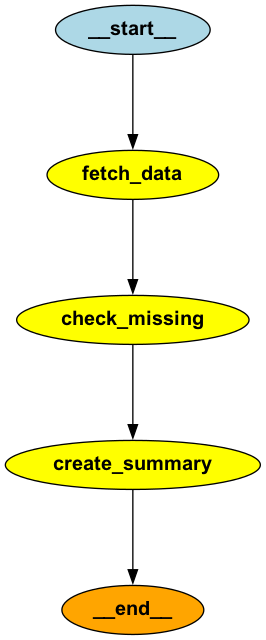

In [9]:
from IPython.display import Image

Image(graph.get_graph().draw_png())

In [10]:
# # 실행 함수
# def process_booking_reference(booking_reference: str):
#     inputs = {"booking_reference": booking_reference}
#     result = graph.invoke(inputs)
#     return result

# # 사용 예시
# if __name__ == "__main__":
#     booking_reference = "EXAMPLE123"
#     result = process_booking_reference(booking_reference)
#     print(f"Summary for booking reference {booking_reference}:")
#     print(result['summary'])


res = graph.invoke({"booking_reference": "CHERRY202409072244"})

In [11]:
res

{'messages': [],
 'data': [{'_id': ObjectId('66e1562f0abd52a6a79a2ff6'),
   'bookingReference': 'CHERRY202409072244',
   'voyageDetails': {'vesselName': 'APL TEMASEK', 'voyageNumber': '2024581E'},
   'routeDetails': {'placeOfReceipt': 'NINGBO',
    'portOfLoading': 'NINGBO',
    'portOfDischarge': 'YANTIAN',
    'placeOfDelivery': 'YANTIAN'},
   'paymentDetails': {'freightPaymentTerms': 'COLLECT',
    'freightPayableAt': 'ROTTERDAM, NETHERLANDS'},
   'documentationDetails': {'blType': 'NEGOTIABLE',
    'numberOfOriginalBLs': 3,
    'numberOfCopies': 0},
   'partyDetails': {'shipper': {'name': 'SHIPPER 5029',
     'address': 'NO. 188, SHANXI ROAD, NINGBO, CHINA',
     'telephone': '+86 574 8765 4321',
     'email': 'INFO@CHINAIMPORTEXPORT.COM'},
    'consignee': {'name': 'EUROTECH TRADING BV',
     'address': 'WATERLOO PLAZA, 121-123 WATERLOOPLEIN, 1011 PG AMSTERDAM, NETHERLANDS',
     'taxId': 'NL856321452B01',
     'president': 'MR. JAN VAN DER WIEL',
     'telephone': '+31 20 624 350

In [12]:
print(res['missing_info'])

This is the summarized report on SI CHERRY202409072244:

1. VESSEL & VOYAGE DETAILS:
   - VESSEL NAME: APL TEMASEK
   - VOYAGE NUMBER: 2024581E

2. PARTY DETAILS:
   - SHIPPER: OK
   - CONSIGNEE: OK
   - NOTIFY PARTY: OK

3. ROUTE DETAILS:
   - PLACE OF RECEIPT: NINGBO
   - PORT OF LOADING: NINGBO
   - PORT OF DISCHARGE: YANTIAN
   - PLACE OF DELIVERY: YANTIAN

4. PAYMENT & DOCUMENTATION:
   - FREIGHT PAYMENT TERMS: COLLECT
   - FREIGHT PAYABLE AT: ROTTERDAM, NETHERLANDS
   - BL TYPE: NEGOTIABLE
   - NUMBER OF ORIGINAL BLs: 3
   - NUMBER OF COPIES: 0

5. SHIPPING INFORMATION:
   - HS CODE: 8541400000
   - COMMODITY DESCRIPTION: POWER TRANSFORMERS

6. CONTAINERS:
   - CONTAINER 1:
     - NUMBER: TCLU9876543
     - SEAL NUMBER: 123456
     - GROSS WEIGHT: 15000.0
     - MEASUREMENT: 30.0
   - CONTAINER 2:
     - NUMBER: TCLU7654321
     - SEAL NUMBER: 654321
     - GROSS WEIGHT: 15000.0
     - MEASUREMENT: 30.0

7. TOTAL SHIPMENT:
   - TOTAL CONTAINERS: TWO (20 O/T X2) CONTAINERS ONLY
  

In [13]:
print(res['summary'])

### Summary of Shipping Instruction Data for CHERRY202409072244

1. **Vessel & Voyage Details:**
   - **Vessel Name:** APL TEMASEK
   - **Voyage Number:** 2024581E

2. **Party Details:**
   - **Shipper:** Complete
   - **Consignee:** Complete
   - **Notify Party:** Complete

3. **Route Details:**
   - **Place of Receipt:** NINGBO
   - **Port of Loading:** NINGBO
   - **Port of Discharge:** YANTIAN
   - **Place of Delivery:** YANTIAN

4. **Payment & Documentation:**
   - **Freight Payment Terms:** COLLECT
   - **Freight Payable At:** ROTTERDAM, NETHERLANDS
   - **BL Type:** NEGOTIABLE
   - **Number of Original BLs:** 3
   - **Number of Copies:** 0

5. **Shipping Information:**
   - **HS Code:** 8541400000
   - **Commodity Description:** POWER TRANSFORMERS

6. **Containers:**
   - **Container 1:**
     - **Number:** TCLU9876543
     - **Seal Number:** 123456
     - **Gross Weight:** 15000.0 kg
     - **Measurement:** 30.0 m³
   - **Container 2:**
     - **Number:** TCLU7654321
     - **S

In [14]:
from pydantic import BaseModel, Field

class VesselRouteDetails(BaseModel):
    vessel_name: str = Field(..., description="Status of Vessel Name (OK/Missing/Warning)")
    voyage_number: str = Field(..., description="Status of Voyage Number (OK/Missing/Warning)")
    place_of_receipt: str = Field(..., description="Status of Place of Receipt (OK/Missing/Warning)")
    port_of_loading: str = Field(..., description="Status of Port of Loading (OK/Missing/Warning)")
    port_of_discharge: str = Field(..., description="Status of Port of Discharge (OK/Missing/Warning)")
    place_of_delivery: str = Field(..., description="Status of Place of Delivery (OK/Missing/Warning)")

class PaymentDocumentation(BaseModel):
    freight_payment_terms: str = Field(..., description="Status of Freight Payment Terms (OK/Missing/Warning)")
    bl_type: str = Field(..., description="Status of Bill of Lading Type (OK/Missing/Warning)")
    number_of_original_bls: str = Field(..., description="Status of Number of Original BLs (OK/Missing/Warning)")

class PartyInformation(BaseModel):
    status: str = Field(..., description="Status of Party Information (OK/Missing/Warning)")

class ShippingDetails(BaseModel):
    status: str = Field(..., description="Status of Shipping Details (OK/Missing/Warning)")

class ContainerInformation(BaseModel):
    status: str = Field(..., description="Status of Container Information (OK/Missing/Warning)")

class TotalShipmentSummary(BaseModel):
    status: str = Field(..., description="Status of Total Shipment Summary (OK/Missing/Warning)")

class AdditionalInformation(BaseModel):
    status: str = Field(..., description="Status of Additional Information (OK/Missing/Warning)")

class SpecialCargoInformation(BaseModel):
    status: str = Field(..., description="Status of Special Cargo Information (OK/Missing/Warning)")

class ShipmentStatus(BaseModel):
    vessel_route_details: VesselRouteDetails = Field(..., description="Details of Vessel and Route status")
    payment_documentation: PaymentDocumentation = Field(..., description="Details of Payment and Documentation status")
    party_information: PartyInformation = Field(..., description="Details of Party Information status")
    shipping_details: ShippingDetails = Field(..., description="Details of Shipping Information status")
    container_information: ContainerInformation = Field(..., description="Details of Container Information status")
    total_shipment_summary: TotalShipmentSummary = Field(..., description="Details of Total Shipment Summary status")
    additional_information: AdditionalInformation = Field(..., description="Details of Additional Information status")
    special_cargo_information: SpecialCargoInformation = Field(..., description="Details of Special Cargo Information status")

In [25]:
from typing import Optional
from pydantic import BaseModel, Field

class StatusWithReason(BaseModel):
    status: str = Field(..., description="The status of the field (OK/Missing/Warning)")
    reason: Optional[str] = Field(None, description="The reason for Missing or Warning status, if applicable")

class VesselRouteDetails(BaseModel):
    vessel_name: StatusWithReason = Field(..., description="Status of Vessel Name")
    voyage_number: StatusWithReason = Field(..., description="Status of Voyage Number")
    place_of_receipt: StatusWithReason = Field(..., description="Status of Place of Receipt")
    port_of_loading: StatusWithReason = Field(..., description="Status of Port of Loading")
    port_of_discharge: StatusWithReason = Field(..., description="Status of Port of Discharge")
    place_of_delivery: StatusWithReason = Field(..., description="Status of Place of Delivery")

class PaymentDocumentation(BaseModel):
    freight_payment_terms: StatusWithReason = Field(..., description="Status of Freight Payment Terms")
    bl_type: StatusWithReason = Field(..., description="Status of Bill of Lading Type")
    number_of_original_bls: StatusWithReason = Field(..., description="Status of Number of Original BLs")

class PartyInformation(BaseModel):
    status: StatusWithReason = Field(..., description="Status of Party Information")

class ShippingDetails(BaseModel):
    status: StatusWithReason = Field(..., description="Status of Shipping Details")

class ContainerInformation(BaseModel):
    status: StatusWithReason = Field(..., description="Status of Container Information")

class TotalShipmentSummary(BaseModel):
    status: StatusWithReason = Field(..., description="Status of Total Shipment Summary")

class AdditionalInformation(BaseModel):
    status: StatusWithReason = Field(..., description="Status of Additional Information")

class SpecialCargoInformation(BaseModel):
    status: StatusWithReason = Field(..., description="Status of Special Cargo Information")

class ShipmentStatus(BaseModel):
    vessel_route_details: VesselRouteDetails = Field(..., description="Details of Vessel and Route status")
    payment_documentation: PaymentDocumentation = Field(..., description="Details of Payment and Documentation status")
    party_information: PartyInformation = Field(..., description="Details of Party Information status")
    shipping_details: ShippingDetails = Field(..., description="Details of Shipping Information status")
    container_information: ContainerInformation = Field(..., description="Details of Container Information status")
    total_shipment_summary: TotalShipmentSummary = Field(..., description="Details of Total Shipment Summary status")
    additional_information: AdditionalInformation = Field(..., description="Details of Additional Information status")
    special_cargo_information: SpecialCargoInformation = Field(..., description="Details of Special Cargo Information status")

In [49]:
from typing import Optional
from pydantic import BaseModel, Field, root_validator

class StatusWithReason(BaseModel):
    status: str = Field(..., description="The status of the field (OK/Missing/Warning)")
    reason: Optional[str] = Field(None, description="The reason for Missing or Warning status, if applicable")

    def is_problematic(self) -> bool:
        return self.status in ["Missing", "Warning"]

class VesselRouteDetails(BaseModel):
    vessel_name: StatusWithReason = Field(..., description="Status of Vessel Name")
    voyage_number: StatusWithReason = Field(..., description="Status of Voyage Number")
    place_of_receipt: StatusWithReason = Field(..., description="Status of Place of Receipt")
    port_of_loading: StatusWithReason = Field(..., description="Status of Port of Loading")
    port_of_discharge: StatusWithReason = Field(..., description="Status of Port of Discharge")
    place_of_delivery: StatusWithReason = Field(..., description="Status of Place of Delivery")
    total_status: str = Field(..., description="Overall status of Vessel Route Details")

    @root_validator(pre=True)
    def calculate_total_status(cls, values):
        statuses = [
            values.get('vessel_name'),
            values.get('voyage_number'),
            values.get('place_of_receipt'),
            values.get('port_of_loading'),
            values.get('port_of_discharge'),
            values.get('place_of_delivery')
        ]
        if any(status.is_problematic() for status in statuses if status):
            values['total_status'] = "Warning"
        else:
            values['total_status'] = "OK"
        return values

class PaymentDocumentation(BaseModel):
    freight_payment_terms: StatusWithReason = Field(..., description="Status of Freight Payment Terms")
    bl_type: StatusWithReason = Field(..., description="Status of Bill of Lading Type")
    number_of_original_bls: StatusWithReason = Field(..., description="Status of Number of Original BLs")
    total_status: str = Field(..., description="Overall status of Payment Documentation")

    @root_validator(pre=True)
    def calculate_total_status(cls, values):
        statuses = [
            values.get('freight_payment_terms'),
            values.get('bl_type'),
            values.get('number_of_original_bls')
        ]
        if any(status.is_problematic() for status in statuses if status):
            values['total_status'] = "Warning"
        else:
            values['total_status'] = "OK"
        return values

class PartyInformation(BaseModel):
    status: StatusWithReason = Field(..., description="Status of Party Information")
    total_status: str = Field(..., description="Overall status of Party Information")

    @root_validator(pre=True)
    def calculate_total_status(cls, values):
        values['total_status'] = values['status'].status
        return values

class ShippingDetails(BaseModel):
    status: StatusWithReason = Field(..., description="Status of Shipping Details")
    total_status: str = Field(..., description="Overall status of Shipping Details")

    @root_validator(pre=True)
    def calculate_total_status(cls, values):
        values['total_status'] = values['status'].status
        return values

class ContainerInformation(BaseModel):
    status: StatusWithReason = Field(..., description="Status of Container Information")
    total_status: str = Field(..., description="Overall status of Container Information")

    @root_validator(pre=True)
    def calculate_total_status(cls, values):
        values['total_status'] = values['status'].status
        return values

class TotalShipmentSummary(BaseModel):
    status: StatusWithReason = Field(..., description="Status of Total Shipment Summary")
    total_status: str = Field(..., description="Overall status of Total Shipment Summary")

    @root_validator(pre=True)
    def calculate_total_status(cls, values):
        values['total_status'] = values['status'].status
        return values

class AdditionalInformation(BaseModel):
    status: StatusWithReason = Field(..., description="Status of Additional Information")
    total_status: str = Field(..., description="Overall status of Additional Information")

    @root_validator(pre=True)
    def calculate_total_status(cls, values):
        values['total_status'] = values['status'].status
        return values

class SpecialCargoInformation(BaseModel):
    status: StatusWithReason = Field(..., description="Status of Special Cargo Information")
    total_status: str = Field(..., description="Overall status of Special Cargo Information")

    @root_validator(pre=True)
    def calculate_total_status(cls, values):
        values['total_status'] = values['status'].status
        return values

class ShipmentStatus(BaseModel):
    vessel_route_details: VesselRouteDetails = Field(..., description="Details of Vessel and Route status")
    payment_documentation: PaymentDocumentation = Field(..., description="Details of Payment and Documentation status")
    party_information: PartyInformation = Field(..., description="Details of Party Information status")
    shipping_details: ShippingDetails = Field(..., description="Details of Shipping Information status")
    container_information: ContainerInformation = Field(..., description="Details of Container Information status")
    total_shipment_summary: TotalShipmentSummary = Field(..., description="Details of Total Shipment Summary status")
    additional_information: AdditionalInformation = Field(..., description="Details of Additional Information status")
    special_cargo_information: SpecialCargoInformation = Field(..., description="Details of Special Cargo Information status")
    total_status: str = Field(..., description="Overall status of the Shipment")

    @root_validator(pre=True)
    def calculate_total_status(cls, values):
        sub_statuses = [
            values['vessel_route_details'].total_status,
            values['payment_documentation'].total_status,
            values['party_information'].total_status,
            values['shipping_details'].total_status,
            values['container_information'].total_status,
            values['total_shipment_summary'].total_status,
            values['additional_information'].total_status,
            values['special_cargo_information'].total_status
        ]
        if "Warning" in sub_statuses:
            values['total_status'] = "Warning"
        else:
            values['total_status'] = "OK"
        return values


/var/folders/1b/dx8_94fs0q740wx3lfknk6y40000gn/T/ipykernel_52771/1744441421.py:20: PydanticDeprecatedSince20: Pydantic V1 style `@root_validator` validators are deprecated. You should migrate to Pydantic V2 style `@model_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.9/migration/
  @root_validator(pre=True)
/var/folders/1b/dx8_94fs0q740wx3lfknk6y40000gn/T/ipykernel_52771/1744441421.py:42: PydanticDeprecatedSince20: Pydantic V1 style `@root_validator` validators are deprecated. You should migrate to Pydantic V2 style `@model_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.9/migration/
  @root_validator(pre=True)
/var/folders/1b/dx8_94fs0q740wx3lfknk6y40000gn/T/ipykernel_52771/1744441421.py:59: PydanticDeprecatedSince20: Pyda

In [59]:
from typing import Optional
from pydantic import BaseModel, Field, root_validator

class StatusWithReason(BaseModel):
    status: str = Field(..., description="The status of the field (OK/Missing/Warning)")
    reason: Optional[str] = Field(None, description="The reason for Missing or Warning status, if applicable")

    def is_problematic(self) -> bool:
        return self.status in ["Missing", "Warning"]

class VesselRouteDetails(BaseModel):
    vessel_name: StatusWithReason = Field(..., description="Status of Vessel Name")
    voyage_number: StatusWithReason = Field(..., description="Status of Voyage Number")
    place_of_receipt: StatusWithReason = Field(..., description="Status of Place of Receipt")
    port_of_loading: StatusWithReason = Field(..., description="Status of Port of Loading")
    port_of_discharge: StatusWithReason = Field(..., description="Status of Port of Discharge")
    place_of_delivery: StatusWithReason = Field(..., description="Status of Place of Delivery")
    total_status: str = Field(..., description="Overall status of Vessel Route Details")

    @root_validator(pre=True)
    def calculate_total_status(cls, values):
        statuses = [
            values.get('vessel_name'),
            values.get('voyage_number'),
            values.get('place_of_receipt'),
            values.get('port_of_loading'),
            values.get('port_of_discharge'),
            values.get('place_of_delivery')
        ]
        if any(status.is_problematic() for status in statuses if status):
            values['total_status'] = "Warning"
        else:
            values['total_status'] = "OK"
        return values

class PaymentDocumentation(BaseModel):
    freight_payment_terms: StatusWithReason = Field(..., description="Status of Freight Payment Terms")
    bl_type: StatusWithReason = Field(..., description="Status of Bill of Lading Type")
    number_of_original_bls: StatusWithReason = Field(..., description="Status of Number of Original BLs")
    total_status: str = Field(..., description="Overall status of Payment Documentation")

    @root_validator(pre=True)
    def calculate_total_status(cls, values):
        statuses = [
            values.get('freight_payment_terms'),
            values.get('bl_type'),
            values.get('number_of_original_bls')
        ]
        if any(status.is_problematic() for status in statuses if status):
            values['total_status'] = "Warning"
        else:
            values['total_status'] = "OK"
        return values

class PartyInformation(BaseModel):
    status: StatusWithReason = Field(..., description="Status of Party Information")
    total_status: str = Field(..., description="Overall status of Party Information")

    @root_validator(pre=True)
    def calculate_total_status(cls, values):
        return {'total_status': values['status'].status}

class ShippingDetails(BaseModel):
    status: StatusWithReason = Field(..., description="Status of Shipping Details")
    total_status: str = Field(..., description="Overall status of Shipping Details")

    @root_validator(pre=True)
    def calculate_total_status(cls, values):
        return {'total_status': values['status'].status}

class ContainerInformation(BaseModel):
    status: StatusWithReason = Field(..., description="Status of Container Information")
    total_status: str = Field(..., description="Overall status of Container Information")

    @root_validator(pre=True)
    def calculate_total_status(cls, values):
        return {'total_status': values['status'].status}

class TotalShipmentSummary(BaseModel):
    status: StatusWithReason = Field(..., description="Status of Total Shipment Summary")
    total_status: str = Field(..., description="Overall status of Total Shipment Summary")

    @root_validator(pre=True)
    def calculate_total_status(cls, values):
        return {'total_status': values['status'].status}

class AdditionalInformation(BaseModel):
    status: StatusWithReason = Field(..., description="Status of Additional Information")
    total_status: str = Field(..., description="Overall status of Additional Information")

    @root_validator(pre=True)
    def calculate_total_status(cls, values):
        return {'total_status': values['status'].status}

class SpecialCargoInformation(BaseModel):
    status: StatusWithReason = Field(..., description="Status of Special Cargo Information")
    total_status: str = Field(..., description="Overall status of Special Cargo Information")

    @root_validator(pre=True)
    def calculate_total_status(cls, values):
        return {'total_status': values['status'].status}

class ShipmentStatus(BaseModel):
    vessel_route_details: VesselRouteDetails = Field(..., description="Details of Vessel and Route status")
    payment_documentation: PaymentDocumentation = Field(..., description="Details of Payment and Documentation status")
    party_information: PartyInformation = Field(..., description="Details of Party Information status")
    shipping_details: ShippingDetails = Field(..., description="Details of Shipping Information status")
    container_information: ContainerInformation = Field(..., description="Details of Container Information status")
    total_shipment_summary: TotalShipmentSummary = Field(..., description="Details of Total Shipment Summary status")
    additional_information: AdditionalInformation = Field(..., description="Details of Additional Information status")
    special_cargo_information: SpecialCargoInformation = Field(..., description="Details of Special Cargo Information status")
    total_status: str = Field(..., description="Overall status of the Shipment")

    @root_validator(pre=True)
    def calculate_total_status(cls, values):
        sub_statuses = [
            values['vessel_route_details'].get('total_status'),
            values['payment_documentation'].get('total_status'),
            values['party_information'].get('total_status'),
            values['shipping_details'].get('total_status'),
            values['container_information'].get('total_status'),
            values['total_shipment_summary'].get('total_status'),
            values['additional_information'].get('total_status'),
            values['special_cargo_information'].get('total_status')
        ]
        if "Warning" in sub_statuses or "Missing" in sub_statuses:
            values['total_status'] = "Warning"
        else:
            values['total_status'] = "OK"
        return values


/var/folders/1b/dx8_94fs0q740wx3lfknk6y40000gn/T/ipykernel_52771/2038545113.py:20: PydanticDeprecatedSince20: Pydantic V1 style `@root_validator` validators are deprecated. You should migrate to Pydantic V2 style `@model_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.9/migration/
  @root_validator(pre=True)
/var/folders/1b/dx8_94fs0q740wx3lfknk6y40000gn/T/ipykernel_52771/2038545113.py:42: PydanticDeprecatedSince20: Pydantic V1 style `@root_validator` validators are deprecated. You should migrate to Pydantic V2 style `@model_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.9/migration/
  @root_validator(pre=True)
/var/folders/1b/dx8_94fs0q740wx3lfknk6y40000gn/T/ipykernel_52771/2038545113.py:59: PydanticDeprecatedSince20: Pyda

In [60]:
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field

# 출력 파서 정의
output_parser = JsonOutputParser(pydantic_object=ShipmentStatus)

format_instructions = output_parser.get_format_instructions()


In [61]:
# print(format_instructions)

In [62]:
MISSING_CHECK_PROMPT = """
Analyze the following Shipping Instruction (SI) data, focusing on missing or incomplete information in key sections excluding the ‘Additional Information’ field.
\n{format_instructions}
\n{data}\n
"""

In [63]:
# prompt 구성
prompt = PromptTemplate(
    template=MISSING_CHECK_PROMPT,
    input_variables=["data"],
    partial_variables={"format_instructions": format_instructions},
)

print(prompt)

input_variables=['data'] input_types={} partial_variables={'format_instructions': 'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"$defs": {"AdditionalInformation": {"properties": {"status": {"$ref": "#/$defs/StatusWithReason", "description": "Status of Additional Information"}, "total_status": {"description": "Overall status of Additional Information", "title": "Total Status", "type": "string"}}, "required": ["status", "total_status"], "title": "AdditionalInformation", "type": "object"}, "ContainerInformation": {"properties": {"status": {"$ref": "#/$defs/StatusWithReason", "descri

In [64]:
# si_data

In [66]:
chain = prompt | llm | output_parser

res = chain.invoke({"data": si_data})
print(res)

{'vessel_route_details': {'vessel_name': {'status': 'OK'}, 'voyage_number': {'status': 'OK'}, 'place_of_receipt': {'status': 'OK'}, 'port_of_loading': {'status': 'OK'}, 'port_of_discharge': {'status': 'OK'}, 'place_of_delivery': {'status': 'OK'}, 'total_status': 'OK'}, 'payment_documentation': {'freight_payment_terms': {'status': 'OK'}, 'bl_type': {'status': 'OK'}, 'number_of_original_bls': {'status': 'OK'}, 'total_status': 'OK'}, 'party_information': {'status': {'status': 'OK'}, 'total_status': 'OK'}, 'shipping_details': {'status': {'status': 'OK'}, 'total_status': 'OK'}, 'container_information': {'status': {'status': 'OK'}, 'total_status': 'OK'}, 'total_shipment_summary': {'status': {'status': 'OK'}, 'total_status': 'OK'}, 'additional_information': {'status': {'status': 'OK'}, 'total_status': 'OK'}, 'special_cargo_information': {'status': {'status': 'Missing', 'reason': 'No special cargo information provided'}, 'total_status': 'Missing'}, 'total_status': 'Warning'}


In [67]:
res

{'vessel_route_details': {'vessel_name': {'status': 'OK'},
  'voyage_number': {'status': 'OK'},
  'place_of_receipt': {'status': 'OK'},
  'port_of_loading': {'status': 'OK'},
  'port_of_discharge': {'status': 'OK'},
  'place_of_delivery': {'status': 'OK'},
  'total_status': 'OK'},
 'payment_documentation': {'freight_payment_terms': {'status': 'OK'},
  'bl_type': {'status': 'OK'},
  'number_of_original_bls': {'status': 'OK'},
  'total_status': 'OK'},
 'party_information': {'status': {'status': 'OK'}, 'total_status': 'OK'},
 'shipping_details': {'status': {'status': 'OK'}, 'total_status': 'OK'},
 'container_information': {'status': {'status': 'OK'}, 'total_status': 'OK'},
 'total_shipment_summary': {'status': {'status': 'OK'}, 'total_status': 'OK'},
 'additional_information': {'status': {'status': 'OK'}, 'total_status': 'OK'},
 'special_cargo_information': {'status': {'status': 'Missing',
   'reason': 'No special cargo information provided'},
  'total_status': 'Missing'},
 'total_status'

In [ ]:
def summarize_data(missing_info):
    # Updated prompt template to generate a summary report from both data and missing info
    prompt_template = """
    You are tasked with generating a detailed shipment summary report based on the provided data.
    
    Here is the shipment data:
    {data}
    
    The following information is missing or problematic:
    {missing_info}
    
    Please generate a summary report that includes:
    1. Overall shipment status.
    2. Key details about the shipment (e.g., vessel route, payment documentation, etc.).
    3. Any missing or problematic information that requires attention.
    4. A conclusion summarizing the shipment's condition (e.g., OK, Warning, Missing).
    """
    
    prompt = PromptTemplate(
        template=prompt_template,
        input_variables=["data", "missing_info"]
    )

    chain = prompt | llm | StrOutputParser()
    try:
        response = chain.invoke({"data": json_util.dumps(data), "missing_info": missing_info})
        return response
    except Exception as e:
        raise RuntimeError(f"Error during summarizing data: {e}")
    